In [1]:
from pycbc.waveform import get_td_waveform
import h5py
from pycbc.filter.matchedfilter import match 
import pycbc 
import pycbc.psd 
import numpy as np
import pycbc.noise 
import pycbc.types 
import pycbc.filter 
import pycbc.waveform
import pycbc.vetoes
import requests
import json
import sys

import rescaling
import best_match

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
sim_path = 'SXS_BBH_0002/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5'
total_mass = 80.

In [3]:
sp, sc = rescaling.rescale(sim_path, total_mass)

In [4]:
tbank = 'bank0729_atlas1_new6.hdf'
f_bank = h5py.File(tbank, 'r')
bank_mass1 = f_bank['mass1'][:]
bank_mass2 = f_bank['mass2'][:]
bank_ecc = f_bank['eccentricity'][:]
bank_lan = f_bank['long_asc_nodes'][:]
bank_inc = f_bank['inclination'][:]
bank_apx = f_bank['approximant'][:]
f_bank.close()

In [5]:
request = requests.get("https://data.black-holes.org/catalog.json", headers={'accept': 'application/citeproc+json'})
sxs_full_json = request.json()
sxs_catalog_json = sxs_full_json['simulations']
mass_ratio = sxs_catalog_json['SXS:BBH:0001']['reference_mass_ratio']
eccentricity = sxs_catalog_json['SXS:BBH:0001']['reference_eccentricity']
sim_m2 = total_mass/(mass_ratio+1.)
sim_m1 = total_mass - sim_m2
print ('Component mass1 = %s' % sim_m1)
print ('Component mass2 = %s' % sim_m2)
print ('Eccentricity = %s' % eccentricity)
f_low = 30.

Component mass1 = 39.9999997989
Component mass2 = 40.0000002011
Eccentricity = 0.0002569


In [ ]:
psd_file ='H1L1-O1_C02_HARM_MEAN_PSD-1126051217-11203200.txt'
ff, best_match_m1, best_match_m2, best_match_ecc, best_match_lan, best_match_inc = best_match.GetBestMatch(comp_mass1=sim_m1, comp_mass2=sim_m2, waveform0=sp, tp_apx=bank_apx, tp_m1=bank_mass1, tp_m2=bank_mass2, tp_ecc=bank_ecc, tp_lan=bank_lan, tp_inc=bank_inc, radius = 0.1, f_low = f_low, psd_file = psd_file)
print ('Fitting factor = %s' % ff)
print ('Best match mass1 = %s' % best_match_m1)
print ('Best match mass2 = %s' % best_match_m2)


In [13]:
flen0 = len(sp)//2 + 1
delta_f0 = sp.delta_f
psd1 = pycbc.psd.read.from_txt(filename = psd_file, length = flen0, delta_f = delta_f0, low_freq_cutoff = f_low, is_asd_file = False)


In [14]:
snr = pycbc.filter.matched_filter(sp, sp, psd = psd1, low_frequency_cutoff = f_low)
snr = snr[len(snr)//4 : len(snr)*3//4]
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
peak_time = snr.sample_times[peak]
snrp_norm = abs(snrp)

scalar = 10./snrp_norm 
rescaled_strains = np.array(sp)*scalar
sp_rescaled = pycbc.types.timeseries.TimeSeries(initial_array = rescaled_strains, delta_t = sp.delta_t)

snr_rescaled = pycbc.filter.matched_filter(sp_rescaled, sp_rescaled, psd = psd1, low_frequency_cutoff = f_low)
snr_rescaled = snr_rescaled[len(snr_rescaled)//4 : len(snr_rescaled)*3//4]
peak_rescaled = abs(snr_rescaled).numpy().argmax()
snrp_rescaled = snr_rescaled[peak_rescaled]
peak_time_rescaled = snr_rescaled.sample_times[peak_rescaled]
snrp_norm_rescaled = abs(snrp_rescaled)

print ('SNR of the rescaled signal: %s' % snrp_norm_rescaled)

SNR of the rescaled signal: 10.000000000000018


In [16]:
delta_t = sp_rescaled.delta_t 
duration = sp_rescaled.duration 
tsamples = int(duration/delta_t)
noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd1, seed = 127)

In [18]:
# generate the template filter 
hp, hc = get_td_waveform(approximant = 'EccentricTD', mass1 = best_match_m1, mass2 = best_match_m2, eccentricity = best_match_ecc, long_asc_nodes = best_match_lan, inclination = best_match_inc, f_lower = f_low, delta_t = delta_t)

signal_plus_noise = sp_rescaled + noise 
delta_f = signal_plus_noise.delta_f 

tlen1 = max(len(hp), len(signal_plus_noise))
hp.resize(tlen1)
signal_plus_noise.resize(tlen1)
flen = tlen1//2 + 1

psd2 = pycbc.psd.read.from_txt(filename = psd_file, length = flen, delta_f = delta_f, low_freq_cutoff = f_low, is_asd_file = False)

num_bins = 16 


In [19]:
chisq = pycbc.vetoes.power_chisq(hp, signal_plus_noise, num_bins, psd2,
                                      low_frequency_cutoff=f_low)
print (chisq)

/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pycbc/types/array.py:382: RuntimeWarning: divide by zero encountered in true_divide
  self._data /= other


[29092.19375107 28953.61687985 28814.4131007  ... 29520.75497167
 29373.20309663 29230.66787636]


In [21]:
m= best_match.GetMatch(hp, signal_plus_noise, psd_file, f_low)
print m

0.5458730310525055


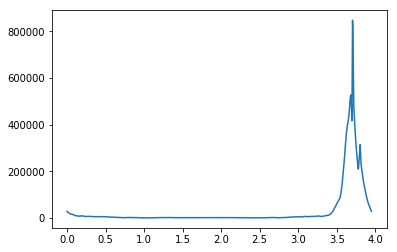

In [22]:
%matplotlib inline
import pylab
pylab.plot(chisq.sample_times, chisq)
pylab.show()